In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
!nvidia-smi

Mon Oct 19 06:05:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
image_size = [224,224]
train = "/content/drive/My Drive/data-20201013T190006Z-001/data/train"
val = "/content/drive/My Drive/data-20201013T190006Z-001/data/val"

IMAGE AUGMENTATION

In [ ]:
training_datagen = ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

train_gen = training_datagen.flow_from_directory(
    train,
    target_size = (100,100),
    class_mode='categorical'
)

Found 1951 images belonging to 4 classes.


In [ ]:
valid_datagen =ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

valid_gen = valid_datagen.flow_from_directory(
    val,
    target_size =(100,100),
    class_mode = "categorical"
)

Found 324 images belonging to 4 classes.


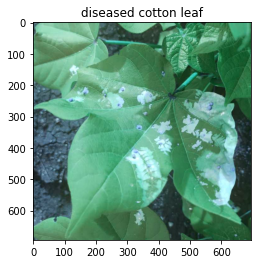

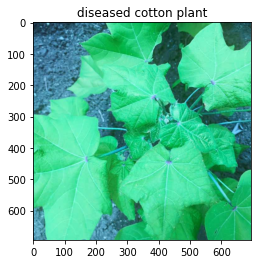

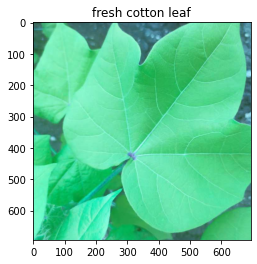

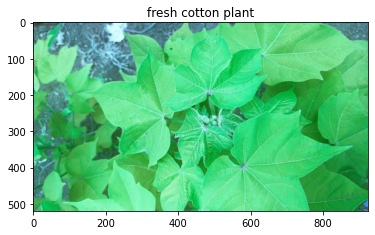

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

categories = ["diseased cotton leaf","diseased cotton plant","fresh cotton leaf","fresh cotton plant"]

for category in categories:
  path = os.path.join(train, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
    plt.title(category)
    plt.imshow(img_array)
    plt.show()
    break

In [ ]:
print(img_array.shape)

(520, 924, 3)


In [ ]:
img_size =100

(100, 100, 3)


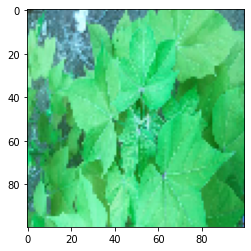

In [ ]:
new_array = cv2.resize(img_array,(img_size, img_size))
print(new_array.shape)
plt.imshow(new_array)

In [ ]:
training = []
comp = [train,val]
def create_train_data():
    for key in comp:
        path1 = os.path.join(key)
        for category in categories:
            path = os.path.join(path1,category)
            class_num = categories.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_UNCHANGED)
                    new_array = cv2.resize(img_array,(img_size,img_size))
                    new_array = new_array/255
                    training.append([new_array,class_num])
                except Exception as e:
                    pass

create_train_data()

In [ ]:
training

[[array([[[0.32156863, 0.42352941, 0.47843137],
          [0.42745098, 0.52941176, 0.55686275],
          [0.24313725, 0.40392157, 0.34117647],
          ...,
          [0.28235294, 0.66666667, 0.50196078],
          [0.36078431, 0.72156863, 0.56078431],
          [0.24313725, 0.6       , 0.40784314]],
  
         [[0.29803922, 0.42352941, 0.4745098 ],
          [0.30588235, 0.51372549, 0.4745098 ],
          [0.49411765, 0.81176471, 0.67843137],
          ...,
          [0.28235294, 0.66666667, 0.50196078],
          [0.36078431, 0.72156863, 0.56078431],
          [0.26666667, 0.58431373, 0.4       ]],
  
         [[0.29019608, 0.40392157, 0.41176471],
          [0.45490196, 0.76470588, 0.64705882],
          [0.50980392, 0.81176471, 0.6745098 ],
          ...,
          [0.25882353, 0.65882353, 0.49411765],
          [0.34509804, 0.72156863, 0.56078431],
          [0.22745098, 0.58039216, 0.38823529]],
  
         ...,
  
         [[0.37647059, 0.55686275, 0.40784314],
          [0.3

In [ ]:
print(len(training))

2275


In [ ]:
import random
random.shuffle(training)
for sample in training[:10]:
    print(sample[1]) 

2
2
1
2
1
0
0
1
1
3


In [ ]:
X = []
y = []

for feature,label in training:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1,img_size,img_size,3)
y = np.array(y)

In [ ]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

In [ ]:
y = pd.get_dummies(y)
y.head()

,0,1,2,3
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,1,0,0


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X,y ,batch_size = 32, epochs=100,validation_split = 0.1, verbose = 1)

Epoch 1/100
64/64 [==============================] - 1s 17ms/step - loss: 0.0844 - accuracy: 0.9717 - val_loss: 0.2249 - val_accuracy: 0.9254
Epoch 2/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0644 - accuracy: 0.9766 - val_loss: 0.1851 - val_accuracy: 0.9430
Epoch 3/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0590 - accuracy: 0.9780 - val_loss: 0.2351 - val_accuracy: 0.9342
Epoch 4/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0761 - accuracy: 0.9692 - val_loss: 0.1758 - val_accuracy: 0.9430
Epoch 5/100
64/64 [==============================] - 1s 16ms/step - loss: 0.1259 - accuracy: 0.9546 - val_loss: 0.2040 - val_accuracy: 0.9079
Epoch 6/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0379 - accuracy: 0.9888 - val_loss: 0.2103 - val_accuracy: 0.9079
Epoch 7/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0606 - accuracy: 0.9766 - val_loss: 0.1937 - val_accuracy: 0.9254
Epoch 

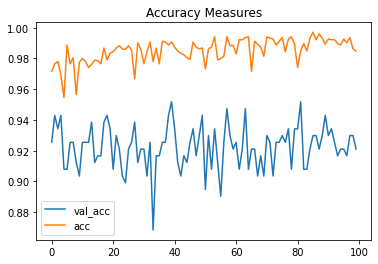

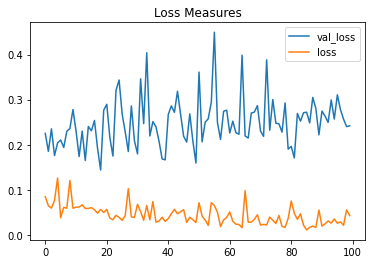

In [ ]:
plt.plot(history.history["val_accuracy"], label='val_acc')
plt.plot(history.history["accuracy"], label='acc')
plt.legend()
plt.title("Accuracy Measures")
plt.show()


plt.plot(history.history["val_loss"],label='val_loss')
plt.plot(history.history["loss"], label='loss')
plt.legend()
plt.title("Loss Measures")
plt.show()

TESTING

In [ ]:
for category in categories:
    path = os.path.join(val,category)
    for image in os.listdir(path):
        image_array = cv2.imread(os.path.join(path,image),cv2.IMREAD_UNCHANGED)
        new_arr = cv2.resize(image_array, (img_size,img_size))
        new_arr = new_arr/255
        pred = model.predict(new_arr.reshape(1,100,100,3))
        print(pred)
        break
    break  

[[1.0000000e+00 8.8476340e-13 1.1587515e-14 9.7364087e-13]]


In [ ]:
pred_index = np.argmax(pred)
print(categories[pred_index])

diseased cotton leaf


In [ ]:
path = os.path.join(val,categories[2]) 
for image in os.listdir(path):
        image_array = cv2.imread(os.path.join(path,image),cv2.IMREAD_UNCHANGED)
        new_arr = cv2.resize(image_array, (img_size,img_size))
        new_arr = new_arr/255
        preds1 = model.predict(new_arr.reshape(1,100,100,3))
        print(preds1)
        break

[[1.0421987e-05 1.0977797e-07 9.9996483e-01 2.4729936e-05]]


In [ ]:
pred_index = np.argmax(preds1)
print(categories[pred_index])

fresh cotton leaf


In [ ]:
model.save("/content/drive/My Drive/data-20201013T190006Z-001/data/model.h5")
print("Saved model to disk")

Saved model to disk
